- LCC
- Image Preprocessing
    - Breast Cropping
    - 224 x 224 pixels
    - Data Augmentation (Random Horizontal Flip)
- Balanced datasets with around 6000 of each classes

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-02-20 19:04:05.114980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 19:04:05.604088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2025-02-20 19:04:06.328500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 19:04:06.328711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 19:04:06.350602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from collections import Counter
import numpy as np
import cv2

In [3]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [4]:
# Define the correct base path
correct_base_path = "/media/yu-tingtseng_sa/Data1"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
# print(data['FilePath'].head())

# Filter out rows with invalid or missing FilePath
data = data.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data = data[data['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

In [5]:
# Map ethnicity to 3 classes
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data = data[data['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

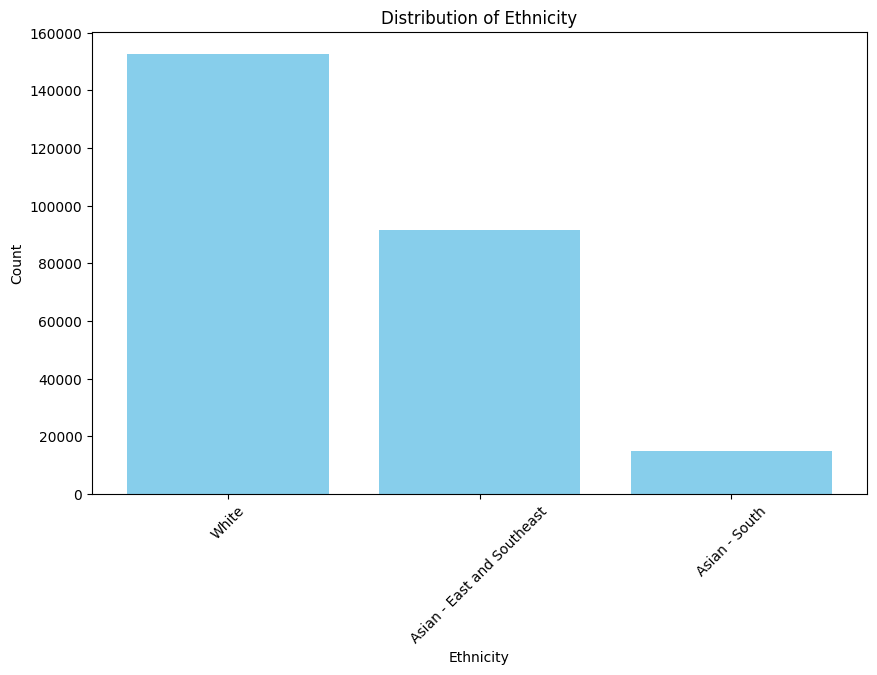

In [23]:
# Count ethnicity distribution
ethnicity_counts = data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Stratified sampling: Select 6000 images per ethnicity
target_per_class = 6000
stratified_samples = []

# For each ethnicity, sample up to 6000
for ethnicity, group in data.groupby('ethnicity'):
    stratified_samples.append(group.sample(
        n=min(target_per_class, len(group)),  # Use all if less than target_per_class
        random_state=42
    ))

# Combine the samples into one DataFrame
data_sample = pd.concat(stratified_samples, ignore_index=True)

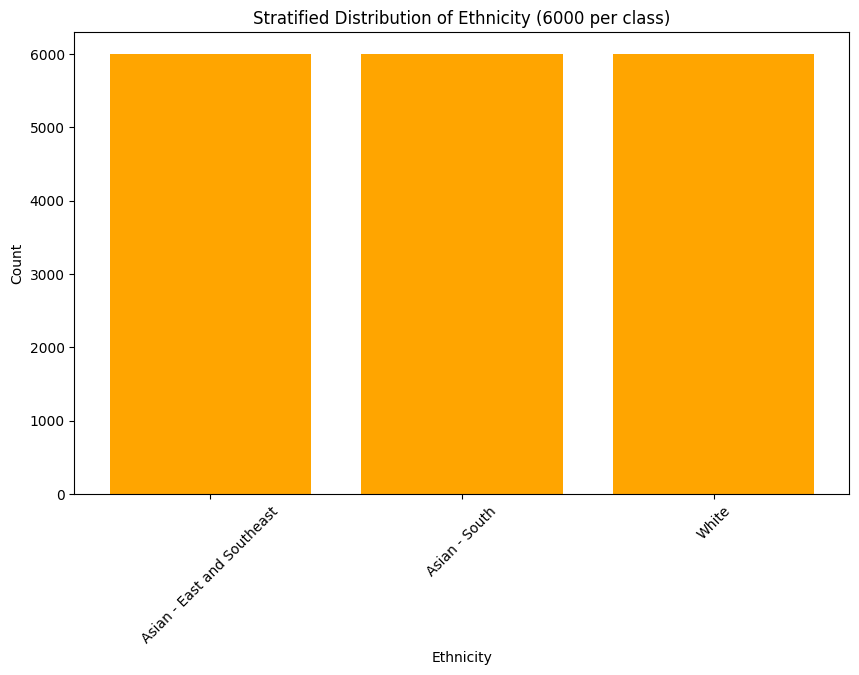

In [24]:
# Show the new distribution of ethnicity
ethnicity_counts = data_sample['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Stratified Distribution of Ethnicity (6000 per class)')
plt.xticks(rotation=45)
plt.show()

### Random Patch

In [12]:
def preprocess(pngPath, output_dir):
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {pngPath}")
    
    # Create a binary image for the breast by thresholding
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
    
    # Find all the contours in the binary image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a mask for the breast region
    mask = np.zeros(img.shape, np.uint8)
    mask = cv2.fillPoly(mask, [largest_contour], 255)
    
    # Find the bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image
    imgCropped = img[y:y+h, x:x+w]
    
    # Select a random patch
    patch_size = 512
    h, w = imgCropped.shape
    x_patch = random.randint(0, max(1, w - patch_size))
    y_patch = random.randint(0, max(1, h - patch_size))
    img_patch = imgCropped[y_patch:y_patch+patch_size, x_patch:x_patch+patch_size]
    
    # Save processed image
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, os.path.basename(pngPath))
    cv2.imwrite(output_path, img_patch)
    
    return output_path, img_patch

### Max tissue patches

In [34]:
def find_max_tissue_patch(img, patch_size=1024):
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
    tissue_map = cv2.integral(binary_img)
    h, w = img.shape
    
    max_tissue = 0
    best_patch = (0, 0)
    
    for _ in range(1000):  # Try multiple random positions
        x = random.randint(0, max(1, w - patch_size))
        y = random.randint(0, max(1, h - patch_size))
        
        if y + patch_size > h or x + patch_size > w:
            continue  # Skip if patch exceeds image dimensions
        
        tissue_count = tissue_map[y + patch_size, x + patch_size] - tissue_map[y, x + patch_size] \
                        - tissue_map[y + patch_size, x] + tissue_map[y, x]
        
        if tissue_count > max_tissue:
            max_tissue = tissue_count
            best_patch = (x, y)
    
    return best_patch

def preprocess(pngPath, output_dir, patch_size=1024):
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {pngPath}")
    
    # Create a binary image for the breast by thresholding
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
    
    # Find all the contours in the binary image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Find the bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image
    imgCropped = img[y:y+h, x:x+w]
    
    # Ensure minimum patch size
    if h < patch_size or w < patch_size:
        pad_h = max(0, patch_size - h)
        pad_w = max(0, patch_size - w)
        imgCropped = cv2.copyMakeBorder(imgCropped, pad_h // 2, pad_h - pad_h // 2, 
                                        pad_w // 2, pad_w - pad_w // 2, 
                                        borderType=cv2.BORDER_CONSTANT, value=0)
        h, w = imgCropped.shape
    
    # Select the 512x512 patch with maximum tissue
    x_patch, y_patch = find_max_tissue_patch(imgCropped, patch_size)
    img_patch = imgCropped[y_patch:y_patch+patch_size, x_patch:x_patch+patch_size]
    
    # Save processed image
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, os.path.basename(pngPath))
    cv2.imwrite(output_path, img_patch)
    
    return output_path, img_patch

### Load Patching Dataset

In [35]:
def encode_labels(labels):
    """Encodes labels into numerical format."""
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

def create_dataset(filepaths, labels, augment=False):
    def load_image(filepath, label):
        image = tf.image.decode_png(tf.io.read_file(filepath), channels=1)
        image = tf.image.resize(image, [1024, 1024])
        
        if augment:
            image = tf.image.random_flip_left_right(image)
        
        return tf.cast(image, tf.float32) / 255.0, label
    
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(lambda filepath, label: load_image(filepath, label),
                          num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [36]:
# Load dataset and preprocess images
output_dir = "/tmp/e3/patching_processed_images"
os.makedirs(output_dir, exist_ok=True)

lcc_only_filepaths = []
lcc_only_labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        if lcc_files:
            try:
                lcc_cropped_path, _ = preprocess(lcc_files[0], output_dir)
                lcc_only_filepaths.append(lcc_cropped_path)
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                lcc_only_labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

/tmp/ipykernel_4023907/101922945.py:16: RuntimeWarning: overflow encountered in scalar subtract
  tissue_count = tissue_map[y + patch_size, x + patch_size] - tissue_map[y, x + patch_size] \
/tmp/ipykernel_4023907/101922945.py:16: RuntimeWarning: overflow encountered in scalar add
  tissue_count = tissue_map[y + patch_size, x + patch_size] - tissue_map[y, x + patch_size] \


In [37]:
# Split dataset into train/test
train_lcc_filepaths, test_lcc_filepaths, train_lcc_labels, test_lcc_labels = train_test_split(
    lcc_only_filepaths, lcc_only_labels, test_size=0.25, stratify=lcc_only_labels, random_state=42
)

# Convert LCC labels to numeric format
encoded_train_lcc_labels, lcc_label_mapping = encode_labels(train_lcc_labels)
encoded_test_lcc_labels = [lcc_label_mapping[label] for label in test_lcc_labels]

# Create training dataset with augmentation
train_lcc_dataset = create_dataset(
    train_lcc_filepaths, encoded_train_lcc_labels, augment=True
).batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create test dataset without augmentation
test_lcc_dataset = create_dataset(
    test_lcc_filepaths, encoded_test_lcc_labels, augment=False
).batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

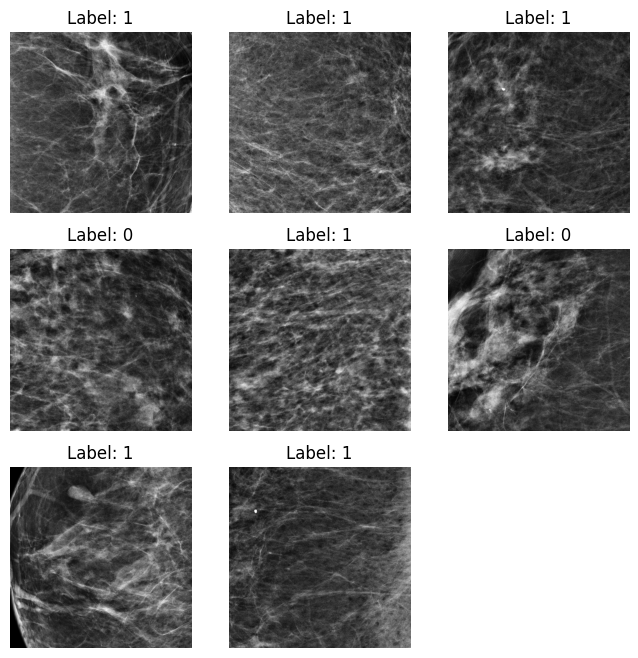

In [38]:
# Function to visualize a batch of images
def show_images_from_dataset(dataset, num_images=9):
    for images, labels in dataset.take(1):  # Take one batch
        images = images.numpy()  # Convert Tensor to NumPy array
        labels = labels.numpy()

        plt.figure(figsize=(8, 8))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
        plt.show()
        break

# Display a batch from the training dataset
show_images_from_dataset(train_lcc_dataset)

### EfficientNetB3

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [39]:
# Define input layer for 1-channel (grayscale) input
input_layer_lcc = Input(shape=(1024, 1024, 1))

# Convert 1-channel grayscale image to 3-channel input using a 1x1 Conv layer
x = Conv2D(3, (1, 1), activation='linear')(input_layer_lcc)

# Load EfficientNetB3 without passing input_tensor, setting input_shape instead
base_model_lcc = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(1024, 1024, 3))

# Apply the grayscale conversion before passing data to EfficientNetB3
x = base_model_lcc(x)

# Freeze base model layers initially
base_model_lcc.trainable = False  

# Add custom layers on top of EfficientNetB3
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_lcc = Dense(len(lcc_label_mapping), activation='softmax')(x)

# Define the final model
model_lcc = Model(inputs=input_layer_lcc, outputs=output_lcc)

# Compile the model
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Start with a smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_lcc = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)

# Fine-tuning (Unfreeze base model for additional training)
base_model_lcc.trainable = True
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again with fine-tuning
history_finetune = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)
    ]
)

Epoch 1/50
1685/1685 [==============================] - 635s 372ms/step - loss: 1.1017 - accuracy: 0.3321 - val_loss: 1.1006 - val_accuracy: 0.3345 - lr: 1.0000e-04
Epoch 2/50
1685/1685 [==============================] - 621s 369ms/step - loss: 1.1002 - accuracy: 0.3316 - val_loss: 1.0996 - val_accuracy: 0.3345 - lr: 1.0000e-04
Epoch 3/50
1685/1685 [==============================] - 621s 369ms/step - loss: 1.0997 - accuracy: 0.3302 - val_loss: 1.0994 - val_accuracy: 0.3345 - lr: 1.0000e-04
Epoch 4/50
1685/1685 [==============================] - 621s 369ms/step - loss: 1.0990 - accuracy: 0.3312 - val_loss: 1.0987 - val_accuracy: 0.3332 - lr: 1.0000e-04
Epoch 5/50
1685/1685 [==============================] - 622s 369ms/step - loss: 1.0994 - accuracy: 0.3278 - val_loss: 1.0989 - val_accuracy: 0.3332 - lr: 1.0000e-04
Epoch 6/50
1685/1685 [==============================] - 622s 369ms/step - loss: 1.0993 - accuracy: 0.3238 - val_loss: 1.0989 - val_accuracy: 0.3332 - lr: 1.0000e-04
Epoch 7/50

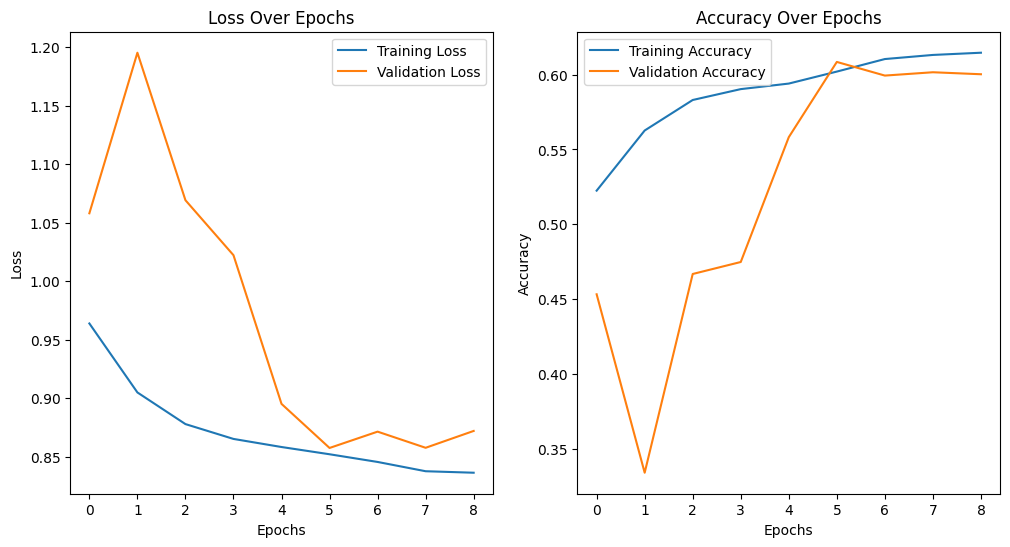

In [40]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

562/562 [==============================] - 57s 100ms/step


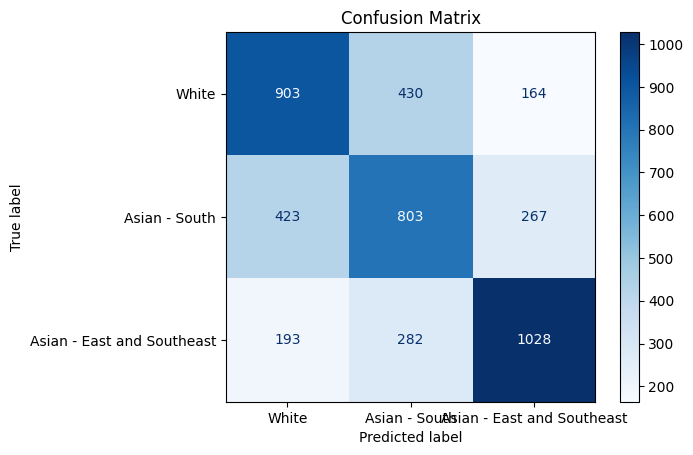

Classification Report:
                            precision    recall  f1-score   support

                     White       0.59      0.60      0.60      1497
             Asian - South       0.53      0.54      0.53      1493
Asian - East and Southeast       0.70      0.68      0.69      1503

                  accuracy                           0.61      4493
                 macro avg       0.61      0.61      0.61      4493
              weighted avg       0.61      0.61      0.61      4493



In [41]:
# Evaluate the model and compute metrics
predictions = model_lcc.predict(test_lcc_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_lcc_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(lcc_label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(lcc_label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))

In [42]:
# Convert confusion matrix to binary format per class
sensitivity = {}
specificity = {}

for i, class_name in enumerate(lcc_label_mapping.keys()):
    # One-vs-all approach
    TP = conf_matrix[i, i]  # True Positives
    FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives
    FP = np.sum(conf_matrix[:, i]) - TP  # False Positives
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

    # Compute sensitivity & specificity
    sensitivity[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[class_name] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print results
print("Sensitivity (Recall) per class:")
for class_name, value in sensitivity.items():
    print(f"{class_name}: {value:.4f}")

print("\nSpecificity per class:")
for class_name, value in specificity.items():
    print(f"{class_name}: {value:.4f}")

Sensitivity (Recall) per class:
White: 0.6032
Asian - South: 0.5378
Asian - East and Southeast: 0.6840

Specificity per class:
White: 0.7944
Asian - South: 0.7627
Asian - East and Southeast: 0.8559


562/562 [==============================] - 55s 98ms/step

Multi-Class AUC-ROC Score: 0.7845


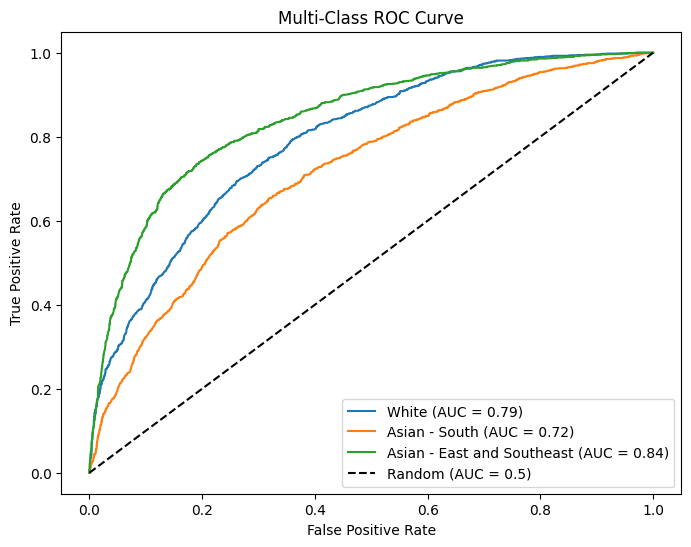

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


# Step 1: Get softmax probabilities
y_probs = model_lcc.predict(test_lcc_dataset)  # Predicted probabilities


# Step 2: Convert true labels into a NumPy array
true_labels = np.array(true_labels)


# Step 3: Binarize true labels (One-hot encoding)
num_classes = y_probs.shape[1]
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))


# Step 4: Compute AUC-ROC score
auc_scores = roc_auc_score(true_labels_bin, y_probs, multi_class='ovr')


print(f"\nMulti-Class AUC-ROC Score: {auc_scores:.4f}")


# Step 5: Plot ROC Curves for Each Class
plt.figure(figsize=(8,6))


for i, class_name in enumerate(lcc_label_mapping.keys()):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')


# Plot diagonal reference line (random chance)
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()


In [ ]:
# Save the model
model_lcc.save('Mammo_EfficientNetB3_3class_1024_model.h5')

/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
